# Import Libraries and CSV Data
##### Debugging or Troubleshooting Code in this notebook was helped by OpenAI's ChatGPT (January 2025)

#### This notebook uses mostly text data and excludes some channel and video specific data
##### If we manage to improve accuravy this would be the ideal data to use
- Excluded Data

    - `v_favorites`,`v_privacy_status`,`c_channel_id`,`v_video_id`,`c_channel_upload_playlist`,
    
    - `c_channel_subCount`,`c_channel_videoCount`,`c_channel_viewCount`,`v_likes`,`v_comment_count`

In [1]:
# Importing libraries
import joblib
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from xgboost import XGBClassifier

# Read in our CSV data
file_path = 'data/english_video_data.csv'
videos_df = pd.read_csv(file_path)
videos_df.head()

,c_channel_id,v_video_id,v_date_publishedAt,v_time_publishedAt,c_channel_title,c_channel_upload_playlist,c_channel_subCount,c_channel_videoCount,c_channel_viewCount,v_category_id,...,v_comment_count,v_likes,v_favorites,v_views,v_definition,v_duration,v_caption,v_age_restricted,v_privacy_status,v_made_for_kids
0,UC295-Dw_tDNtZXFeAPAW6Aw,oGga7hZypCs,2024-09-02,11:00:48,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,28,442,0,76602,hd,2:03:35,False,Not Restricted,public,False
1,UC295-Dw_tDNtZXFeAPAW6Aw,pkzIiXkRxB0,2024-08-30,11:00:54,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,21,1165,0,341133,hd,2:01:48,False,Not Restricted,public,False
2,UC295-Dw_tDNtZXFeAPAW6Aw,TUS8vZaHNds,2024-08-31,11:00:26,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,43,1374,0,222425,hd,1:00:04,False,Not Restricted,public,False
3,UC295-Dw_tDNtZXFeAPAW6Aw,rBzKTkUG3Wk,2024-08-31,13:00:57,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,19,274,0,40821,hd,1:01:09,False,Not Restricted,public,False
4,UC295-Dw_tDNtZXFeAPAW6Aw,XHQP6mut8YI,2024-09-01,11:00:36,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,27,485,0,82374,hd,0:20:16,False,Not Restricted,public,False


## Data Preprocessing

In [2]:
# Make sure descriptions have a blank string rather than nothing 
videos_df['v_description'] = videos_df['v_description'].fillna("")

# Remove some columns that we wont need in this model
videos_df_2 = videos_df.drop(['v_favorites','v_privacy_status','c_channel_id','v_video_id','c_channel_upload_playlist',
                              'c_channel_subCount','c_channel_videoCount','c_channel_viewCount','v_likes','v_comment_count'], axis=1)

In [3]:
# Change the way duration, date published, and time published are formatted
videos_df_2['v_date_publishedAt'] = videos_df_2['v_date_publishedAt'].astype('datetime64[s]')
videos_df_2['v_time_publishedAt'] = videos_df_2['v_time_publishedAt'].astype('datetime64[s]')

videos_df_2['v_year'] = videos_df_2['v_date_publishedAt'].dt.year
videos_df_2['v_mont'] = videos_df_2['v_date_publishedAt'].dt.month
videos_df_2['v_day'] = videos_df_2['v_date_publishedAt'].dt.day
videos_df_2['v_hour'] = videos_df_2['v_time_publishedAt'].dt.hour
videos_df_2['v_minute'] = videos_df_2['v_time_publishedAt'].dt.minute
videos_df_2['v_second'] = videos_df_2['v_time_publishedAt'].dt.second

videos_df_2.drop(['v_date_publishedAt', 'v_time_publishedAt'], axis=1, inplace=True)

videos_df_2['v_duration_time'] = pd.to_timedelta(videos_df_2['v_duration'])

videos_df_2['v_duration_time'] = videos_df_2['v_duration_time'].dt.total_seconds()

videos_df_2.drop(['v_duration'], axis=1, inplace=True)

In [4]:
# list of all category names from Youtube with their ID's
categories = {
    1: "Film & Animation",
    2: "Autos & Vehicles",
    10: "Music",
    15: "Pets & Animals",
    17: "Sports",
    18: "Short Movies",
    19: "Travel & Events",
    20: "Gaming",
    21: "Videoblogging",
    22: "People & Blogs",
    23: "Comedy",
    24: "Entertainment",
    25: "News & Politics",
    26: "Howto & Style",
    27: "Education",
    28: "Science & Technology",
    29: "Nonprofits & Activism",
    30: "Movies",
    31: "Anime/Animation",
    32: "Action/Adventure",
    33: "Classics",
    34: "Comedy",
    35: "Documentary",
    36: "Drama",
    37: "Family",
    38: "Foreign",
    39: "Horror",
    40: "Sci-Fi/Fantasy",
    41: "Thriller",
    42: "Shorts",
    43: "Shows",
    44: "Trailers"
}

# Function to change category id to the category name
def name_categories(df, category_dict):
    for index, row in df.iterrows():
        if row['v_category_id'] in [23, 10, 17, 15, 19]:
            df.at[index, 'v_category_id'] = "other"
        elif row['v_category_id'] in category_dict:
            df.at[index, 'v_category_id'] = category_dict[row['v_category_id']]

    return df

In [5]:
# Uses function above to change category
videos_df_cats = name_categories(videos_df_2, categories)

C:\Users\papad\AppData\Local\Temp\ipykernel_7704\917203685.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Howto & Style' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, 'v_category_id'] = category_dict[row['v_category_id']]


In [6]:
# This will randomize the order of our datafram since the CSV that was read in was sorted
videos_df_cats = videos_df_cats.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
# Get dummies for certain columns
videos_df_dummies = pd.get_dummies(data= videos_df_cats, columns=['v_category_id','v_definition','v_caption','v_age_restricted','v_made_for_kids'],dtype=int)

In [8]:
# Function to bucket our views column for our models to use as target(y)
def bucket_views(df, column_name):
    bins = [-1, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, float("inf")]
    labels = [
        "Very Low (0 - 1K)",
        "Low (1K - 5K)",
        "Moderate (5K - 10K)",
        "Growing (10K - 50K)",
        "Established (50K - 100K)",
        "Popular (100K - 500K)",
        "Trending (500K - 1M)",
        "Viral (1M+)"
    ]
    df["view_bucket"] = pd.cut(df[column_name], bins=bins, labels=labels, right=True)
    
    return df

In [9]:
# Use the function bucket_views to bucket each video viewcount
bucket_video_df = bucket_views(videos_df_dummies, 'v_views')
bucket_video_df.drop(columns=['v_views'], axis=1, inplace =True)
bucket_video_df['view_bucket'].value_counts()

view_bucket
Low (1K - 5K)               6825
Very Low (0 - 1K)           5072
Growing (10K - 50K)         4546
Moderate (5K - 10K)         3334
Popular (100K - 500K)       1235
Established (50K - 100K)    1039
Viral (1M+)                  251
Trending (500K - 1M)         214
Name: count, dtype: int64

In [10]:
# Use labelencoder to change bucket names to numeric
encoder = LabelEncoder()
bucket_video_df["video_views_bucket_encoded"] = encoder.fit_transform(bucket_video_df["view_bucket"])

In [11]:
# Drop columns that wont be used
bucket_video_df = bucket_video_df.drop(columns=['v_caption_False','v_made_for_kids_False','view_bucket'])

In [12]:
# Split our data into text columns and numeric columns
text_columns = ['c_channel_title', 'v_tags', 'v_title','v_description']
numeric_columns = [col for col in bucket_video_df.columns if (col not in text_columns) and (col != 'video_views_bucket_encoded')]

In [13]:
# Function to clean up lines to not include links or the word video/channel
def remove_urls(description):
    clean_text = re.sub(r"http\S+|www\S+|https\S+", "", description, flags=re.MULTILINE)
    clean_text = re.sub(rf"\b{re.escape('video')}\b", "", clean_text, flags=re.IGNORECASE)
    clean_text = re.sub(rf"\b{re.escape('channel')}\b", "", clean_text, flags=re.IGNORECASE)
    return clean_text

## Beginning of Model Building

In [14]:
# Split our data into Features and Target
y = bucket_video_df['video_views_bucket_encoded']
X = bucket_video_df.drop(columns=['video_views_bucket_encoded'])

In [15]:
# Split our data into testing and training data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
# this will break down text columns into seperate words using remove_urls to clean out some things
text_transformer = CountVectorizer(stop_words='english', preprocessor=remove_urls, ngram_range=(1,1))
text_train_transformed = text_transformer.fit_transform(X_train[text_columns].apply(lambda x: ' '.join(x), axis=1))  # Convert text columns into a single string
text_test_transformed = text_transformer.transform(X_test[text_columns].apply(lambda x: ' '.join(x), axis=1))

# Make sure shapes match up
print("Text train shape:", text_train_transformed.shape)
print("Text test shape:", text_test_transformed.shape)
print("Numeric train shape:", X_train[numeric_columns].shape)
print("Numeric test shape:", X_test[numeric_columns].shape)

# Re-combine text data and numeric data
X_train_combined = hstack([text_train_transformed, X_train[numeric_columns]])
X_test_combined = hstack([text_test_transformed, X_test[numeric_columns]])

# Make sure shapes match up
print("Combined train shape:", X_train_combined.shape)
print("Combined test shape:", X_test_combined.shape)

Text train shape: (18012, 67519)
Text test shape: (4504, 67519)
Numeric train shape: (18012, 24)
Numeric test shape: (4504, 24)
Combined train shape: (18012, 67543)
Combined test shape: (4504, 67543)


In [17]:
# Function to get Feature names and display the top 20 by value
def display_top_features(text_transformer, numeric_columns, model):
    # Get feature names
    text_feature_names = text_transformer.get_feature_names_out().tolist()
    numeric_feature_names = list(numeric_columns)
    combined_feature_names = list(text_feature_names) + numeric_feature_names

    # Get the importance of each feature
    importances = model.feature_importances_

    # Sort feature by importance
    indices = np.argsort(importances)[::-1]

    # Get the top 20 by importance
    top_20_indices = indices[:20]
    combined_feature_names = [combined_feature_names[i] for i in top_20_indices]
    combined_importances = importances[top_20_indices]

    # Display a bar graph showing top 20 by importance
    plt.figure(figsize=(10,6))
    plt.title("Top 20 Feature Importance")
    plt.bar(range(len(combined_importances)), combined_importances, align="center")
    plt.xticks(range(len(combined_importances)), combined_feature_names, rotation=90)
    plt.show()

    return

### Random Forest Model

In [18]:
# Random Forest Hyperparameters
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=None, 
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1,
    class_weight='balanced'
)

# Train the model and get predictions
rf_model.fit(X_train_combined, y_train)
rf_y_pred = rf_model.predict(X_test_combined)

# Show accuracy, cofusion matric, and classification report
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f"Accuracy: {rf_accuracy*100:.3f}%")
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_y_pred))
print("Classification Report:\n", classification_report(y_test, rf_y_pred))

# Save the model
joblib.dump(rf_model, "model/rf_model_text.pkl")

Accuracy: 55.551%
Confusion Matrix:
 [[ 21 102  24  20  47   2   7   1]
 [ 12 524 197 111  25   1  26   0]
 [  2  69 923 107   2   0 246   0]
 [  0 208 268 175   4   0  38   0]
 [ 27 100  18   5 110   3   3   4]
 [  1  16   2   3  15   1   0   5]
 [  0   5 218   4   0   0 741   0]
 [  0  25   5   3  19   1   1   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.09      0.15       224
           1       0.50      0.58      0.54       896
           2       0.56      0.68      0.61      1349
           3       0.41      0.25      0.31       693
           4       0.50      0.41      0.45       270
           5       0.12      0.02      0.04        43
           6       0.70      0.77      0.73       968
           7       0.41      0.11      0.18        61

    accuracy                           0.56      4504
   macro avg       0.44      0.37      0.38      4504
weighted avg       0.53      0.56      0.53      4504



['model/rf_model_text.pkl']

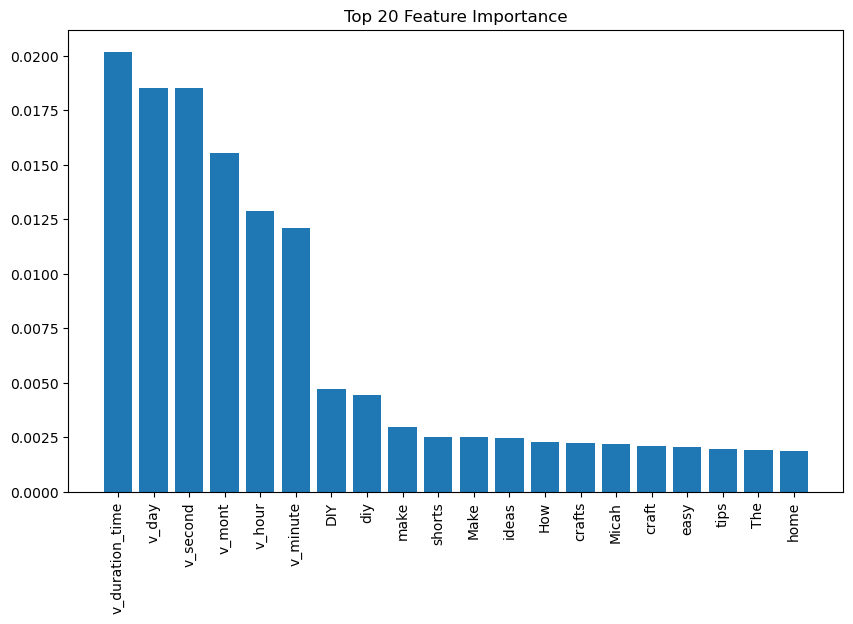

In [19]:
# Display top 20 features
display_top_features(text_transformer,numeric_columns,rf_model)

### XGBoost Model

In [20]:
# XGB Hyperparameters
xgb_model = XGBClassifier(
    random_state=42,
    max_depth=20,
    learning_rate=0.05,
    n_estimators=1000,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
)

# Train the model and get predictions
xgb_model.fit(X_train_combined, y_train)
xgb_y_pred = xgb_model.predict(X_test_combined)

# Show accuracy, cofusion matric, and classification report
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
print(f"Accuracy: {xgb_accuracy*100:.3f}%")
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_y_pred))
print("Classification Report:\n", classification_report(y_test, xgb_y_pred))

# Save the model
xgb_model.save_model("model/xgb_model_text.json")
joblib.dump(xgb_model, "model/xgb_model_text.pkl")

Accuracy: 56.528%
Confusion Matrix:
 [[ 30  93  20  24  43   5   8   1]
 [ 15 529 165 140  19   0  27   1]
 [  1  73 930 101   2   0 242   0]
 [  1 194 240 222   1   0  34   1]
 [ 45  84  29   6  95   5   1   5]
 [  1  19   3   0  11   2   0   7]
 [  0   5 231   2   0   0 730   0]
 [  2  25   6   1  18   1   0   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.13      0.19       224
           1       0.52      0.59      0.55       896
           2       0.57      0.69      0.63      1349
           3       0.45      0.32      0.37       693
           4       0.50      0.35      0.41       270
           5       0.15      0.05      0.07        43
           6       0.70      0.75      0.73       968
           7       0.35      0.13      0.19        61

    accuracy                           0.57      4504
   macro avg       0.44      0.38      0.39      4504
weighted avg       0.55      0.57      0.55      4504



['model/xgb_model_text.pkl']

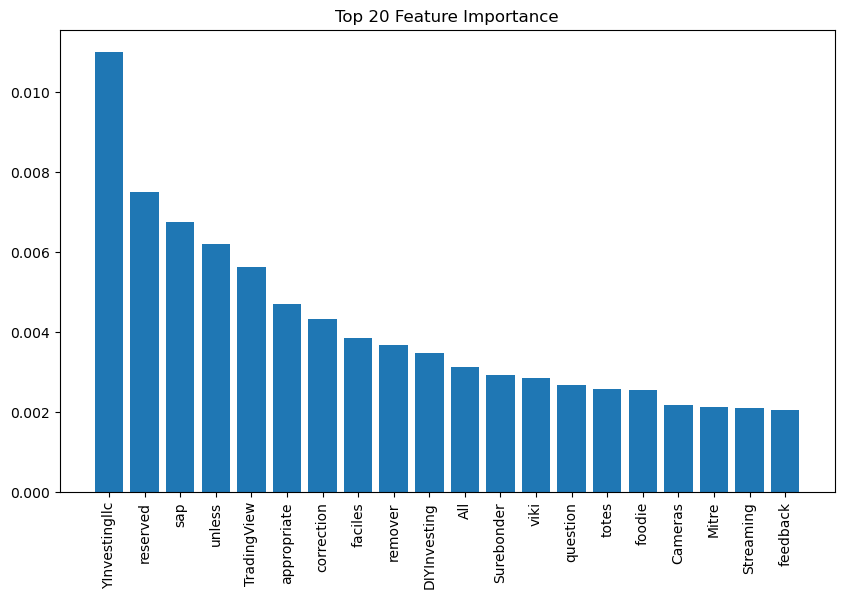

In [21]:
# Display top 20 features
display_top_features(text_transformer,numeric_columns,xgb_model)

### Neural Network Model

In [22]:
# Define the neural network model
number_input_features = X_train_combined.shape[1]
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 4
hidden_nodes_layer3 = 1

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation="relu", input_dim=number_input_features))
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))
# Output layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="sigmoid"))

# Check the structure of the model
nn.summary()

c:\Users\papad\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │       540,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 540,393 (2.06 MB)

 Trainable params: 540,393 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_combined, y_train, epochs=100)

Epoch 1/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.1972 - loss: -1077.4110
Epoch 2/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2033 - loss: -31475.9043
Epoch 3/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2084 - loss: -152240.3594
Epoch 4/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2015 - loss: -409644.0938
Epoch 5/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2036 - loss: -820471.0625
Epoch 6/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2055 - loss: -1399618.8750
Epoch 7/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1968 - loss: -2189510.7500
Epoch 8/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2080 - loss: -3097786.7500
Epoch 9/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2044 - loss: -4368527.5000
Epoch 10/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1993 - loss: -5692543.5000
Epoch 11/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0

In [24]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_combined,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

141/141 - 1s - 5ms/step - accuracy: 0.1989 - loss: -2.5223e+09
Loss: -2522317824.0, Accuracy: 0.19893428683280945


In [25]:
# Export our model to HDF5 file
nn.save('model/video_nn_model.h5')